# Tuning the Richardson-Lucy Algorithm with 1D functions

Its faster and simpler to experiment with 1D functions than 2D images. The same algorithm is used in 1D as it is in 2D. Furthermore there is more 1D data than 2D data.

# Aims
- Understand how random noise is changed by convolution
- Test the Richardson-Lucy Algorithm (RLA) in 1D
- Tune the RLA parameters in order to maximize $R^2$ and minimize MSE
## Deconvolving a 1D signal
A square wave was convolved using a gaussian kernel and then poisson noise was added. The square wave was normalized between $0$ and $1$ as this was the 2D signal (image) was prepared as the same algorithms were used. The RLA was then used to try and recover the original signal.

In [1]:
import torch
import matplotlib.pyplot as plt
from ImageDebluring import *
from PIL import Image
from torchvision import transforms


def step_function(period=2.0):
    xs = torch.linspace(-5, 5, steps=1000)
    ys = (((xs.round() % period) == 0).float() + 0.2)/2
    return xs, ys

def sin_function(period=2.0):
    xs = torch.linspace(-5, 5, steps=1000)
    ys = (torch.sin(xs * (2 * torch.pi / period)) + 1) / 2
    return xs, ys

def pigeon_function():
    image = Image.open('Images/pigeon.jpeg').convert('L')  # Convert to grayscale
    transform = transforms.Compose([
        transforms.Resize((1, 1000)),  # Resize to 1x1000
        transforms.ToTensor()
    ])
    img_tensor = transform(image).squeeze()  # Remove channel dimension
    return torch.linspace(0, 10, steps=1000), img_tensor

num_iters = 6
scale_factor = 5000

x, y = step_function()
signal = y.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
kernel = gaussian_normalised_kernel_1D(size = 61, sigma = 10.0)

blurred_signal = convolution_1D(signal, kernel)
measured_signal = add_poisson_noise(blurred_signal, scale_factor=scale_factor)

deblurred_signal = richardson_lucy(measured_signal, kernel, num_iters=num_iters)

fig, axs = plt.subplots(3, 2, figsize=(12, 8))
axs[0, 0].plot(y)
axs[0, 0].set_title('Step Function')
axs[1, 0].plot(kernel.squeeze())
axs[1, 0].set_title('Gaussian Kernel (1D)')
axs[2, 0].plot(measured_signal.squeeze())
axs[2, 0].set_title('Measured Signal (Blurred + Noisy)')
axs[0, 1].plot(blurred_signal.squeeze())
axs[0, 1].set_title('Blurred Signal')
axs[2, 1].plot(deblurred_signal.squeeze())
axs[2, 1].set_title(f'Deblurred Signal (Richardson-Lucy, {num_iters} iters)')
plt.tight_layout()

ModuleNotFoundError: No module named 'torch'

## Number of iterations

Its also easier to find training datasets for machine learning algorithms in 1D. The Richardson lucy algorithm has 3 "tuning parameters" the first is the convolution kernel which is assumed to be a guassian with known standard deviation. The second is the number of iterations the algorithm runs for. The third is the initial guess.

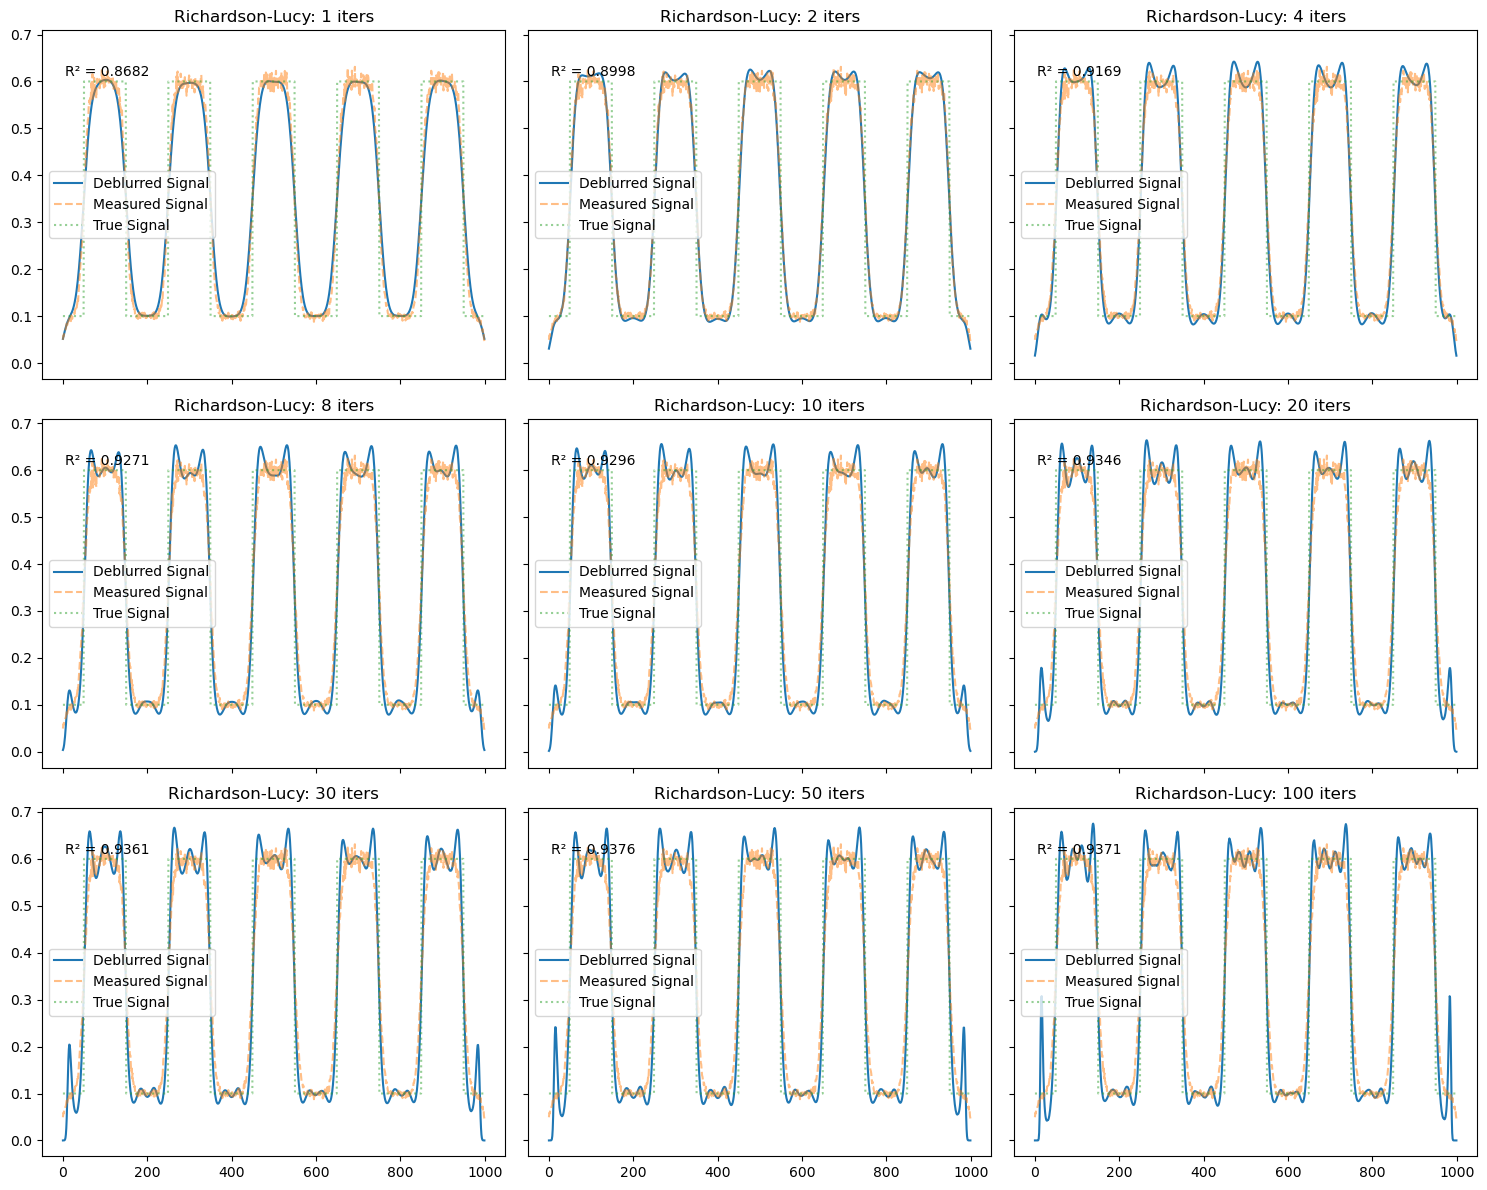

In [13]:
import torchmetrics

iters = [1,2,4,8,10,20,30,50,100]
fig, axs = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)
axs = axs.flatten()
for i, it in enumerate(iters):
    deblurred_signal = richardson_lucy(measured_signal, kernel, num_iters=it)
    axs[i].plot(deblurred_signal.squeeze())
    axs[i].plot(measured_signal.squeeze(), linestyle='dashed', alpha=0.5)
    axs[i].plot(y.squeeze(), linestyle='dotted', alpha=0.5)
    axs[i].plot()
    axs[i].legend(['Deblurred Signal', 'Measured Signal', 'True Signal'])
    axs[i].set_title(f'Richardson-Lucy: {it} iters')
    r2 = torchmetrics.functional.r2_score(deblurred_signal.squeeze(), y.squeeze())
    axs[i].text(0.05, 0.9, f'R² = {r2:.4f}', transform=axs[i].transAxes, fontsize=10, verticalalignment='top')
fig.tight_layout()



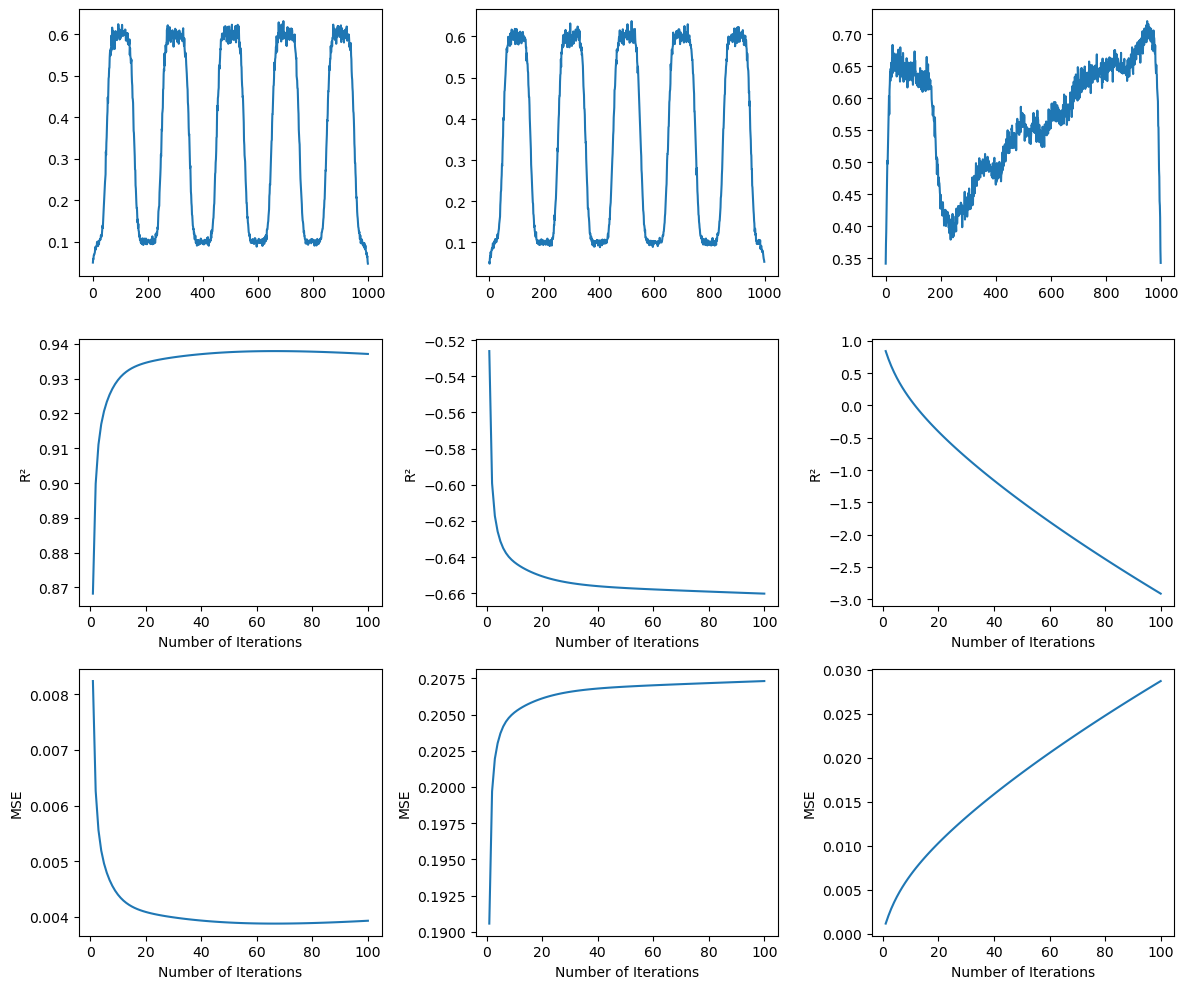

In [14]:
r2s = []
mses = []
r2s2 = []
mses2 = []
r2s3 = []
mses3 = []

x2, y2 = sin_function()
signal2 = y.unsqueeze(0).unsqueeze(0)  
blured_signal2 = convolution_1D(signal2, kernel)
measured_signal2 = add_poisson_noise(blured_signal2, scale_factor=scale_factor)

x3, y3 = pigeon_function()
signal3 = y3.unsqueeze(0).unsqueeze(0)  
blured_signal3 = convolution_1D(signal3, kernel)
measured_signal3 = add_poisson_noise(blured_signal3, scale_factor=scale_factor)

for i in range(1,101):
    deblurred_signal = richardson_lucy(measured_signal, kernel, num_iters=i)
    deblurred_signal2 = richardson_lucy(measured_signal2, kernel, num_iters=i)
    deblurred_signal3 = richardson_lucy(measured_signal3, kernel, num_iters=i)
    r2 = torchmetrics.functional.r2_score(deblurred_signal.squeeze(), y.squeeze())
    r22 = torchmetrics.functional.r2_score(deblurred_signal2.squeeze(), y2.squeeze())
    r23 = torchmetrics.functional.r2_score(deblurred_signal3.squeeze(), y3.squeeze())
    mse = torch.mean((deblurred_signal - y)**2).item()
    mse2 = torch.mean((deblurred_signal2 - y2)**2).item()
    mse3 = torch.mean((deblurred_signal3 - y3)**2).item()
    r2s.append(r2.item())
    r2s2.append(r22.item())
    r2s3.append(r23.item())
    mses.append(mse)
    mses2.append(mse2)
    mses3.append(mse3)

fig, axs = plt.subplots(3, 3, figsize=(12, 10))

axs[0, 0].plot(measured_signal.squeeze())

axs[1, 0].plot(range(1, 101), r2s)
axs[1, 0].set_xlabel('Number of Iterations')
axs[1, 0].set_ylabel('R²')

axs[2, 0].plot(range(1, 101), mses)
axs[2, 0].set_xlabel('Number of Iterations')
axs[2, 0].set_ylabel('MSE')

axs[0, 1].plot(measured_signal2.squeeze())

axs[1, 1].plot(range(1, 101), r2s2)
axs[1, 1].set_xlabel('Number of Iterations')
axs[1, 1].set_ylabel('R²')

axs[2, 1].plot(range(1, 101), mses2)
axs[2, 1].set_xlabel('Number of Iterations')
axs[2, 1].set_ylabel('MSE')

axs[0, 2].plot(measured_signal3.squeeze())

axs[1, 2].plot(range(1, 101), r2s3)
axs[1, 2].set_xlabel('Number of Iterations')
axs[1, 2].set_ylabel('R²')

axs[2, 2].plot(range(1, 101), mses3)
axs[2, 2].set_xlabel('Number of Iterations')
axs[2, 2].set_ylabel('MSE')

fig.tight_layout()

## Discussion
